# 🧱 Plan du notebook `03_vocab_building.ipynb`

| Étape | Objectif                                             |
| ----- | ---------------------------------------------------- |
| 1️⃣   | Chargement et visualisation des captions             |
| 2️⃣   | Nettoyage des captions (`clean_caption`)             |
| 3️⃣   | Tokenisation + stats globales                        |
| 4️⃣   | Construction du vocabulaire avec `min_word_freq`     |
| 5️⃣   | Ajout des tokens spéciaux `<pad>`, `<start>`, ...    |
| 6️⃣   | Création d’un objet `Tokenizer` (avec encode/decode) |
| 7️⃣   | Sauvegarde du tokenizer                              |
| 8️⃣   | (Optionnel) Visualisation / histogramme fréquence    |


## 🔁 Étape 1 : Chargement des captions

In [1]:
from pathlib import Path

captions_file = Path("../data/raw/Flickr8k_text/Flickr8k.token.txt")

with open(captions_file, "r") as f:
    lines = f.readlines()

print(f"Nombre total de lignes : {len(lines)}")
print("Exemple :")
print(lines[0])


Nombre total de lignes : 40460
Exemple :
1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .



🔎 Explication :

- Le fichier contient toutes les captions sous la forme :
`1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .`

- On va ensuite regrouper toutes les captions par image

## 🔁 Étape 1 (suite) : parser et regrouper les captions

In [2]:
from collections import defaultdict

# 🔄 Dictionnaire image_id -> liste de captions
captions_dict = defaultdict(list)

for line in lines:
    try:
        image_name, caption = line.strip().split('\t')
        image_id = image_name.split('#')[0].split('.')[0]  # enlève le .jpg
        captions_dict[image_id].append(caption)
    except ValueError:
        print(f"Ligne ignorée : {line.strip()}")

print(f"📸 Nombre d'images avec légendes : {len(captions_dict)}")
example_id = next(iter(captions_dict))
print(f"\n🖼️ Exemple image_id : {example_id}")
for i, cap in enumerate(captions_dict[example_id]):
    print(f"  ➤ Caption {i+1}: {cap}")


📸 Nombre d'images avec légendes : 8092

🖼️ Exemple image_id : 1000268201_693b08cb0e
  ➤ Caption 1: A child in a pink dress is climbing up a set of stairs in an entry way .
  ➤ Caption 2: A girl going into a wooden building .
  ➤ Caption 3: A little girl climbing into a wooden playhouse .
  ➤ Caption 4: A little girl climbing the stairs to her playhouse .
  ➤ Caption 5: A little girl in a pink dress going into a wooden cabin .


### ✅ Explication ligne par ligne :

| Ligne               | Fonction                                                     |
| ------------------- | ------------------------------------------------------------ |
| `defaultdict(list)` | crée un dict où chaque valeur par défaut est une liste       |
| `split('\t')`       | sépare l’image et la légende                                 |
| `split('#')[0]`     | retire le numéro de la légende (#0, #1...)                   |
| `split('.')[0]`     | retire l’extension `.jpg` pour ne garder que l’ID            |
| `.append(caption)`  | ajoute chaque caption dans la liste correspondante à l’image |


## ✨ Étape 2 : Nettoyage des captions (clean_caption)

### ✅ Objectifs :
- Tout passer en minuscule

- Supprimer ponctuation, caractères spéciaux, chiffres

- Garder uniquement les mots

- Éventuellement supprimer les mots très courts

#### 📦 Fonction clean_caption()

In [3]:
import re

def clean_caption(caption):
    caption = caption.lower()
    caption = re.sub(r"[^a-zA-Z0-9\s']", "", caption)  # garde les apostrophes
    caption = re.sub(r"\s+", " ", caption)
    return caption.strip()


#### 🧪 Application à toutes les captions

In [4]:
from collections import Counter

cleaned_captions_dict = {}
all_tokens = []

for img_id, captions in captions_dict.items():
    cleaned = []
    for c in captions:
        c_clean = clean_caption(c)
        tokens = c_clean.split()
        all_tokens.extend(tokens)
        cleaned.append(c_clean)
    cleaned_captions_dict[img_id] = cleaned

# 🔍 Exemple vérification
example_id = next(iter(cleaned_captions_dict))
print(f"\n🧼 Captions nettoyées pour {example_id} :")
for c in cleaned_captions_dict[example_id]:
    print("  ➤", c)

# 🧠 Comptage des tokens pour vocabulaire
word_freq = Counter(all_tokens)



🧼 Captions nettoyées pour 1000268201_693b08cb0e :
  ➤ a child in a pink dress is climbing up a set of stairs in an entry way
  ➤ a girl going into a wooden building
  ➤ a little girl climbing into a wooden playhouse
  ➤ a little girl climbing the stairs to her playhouse
  ➤ a little girl in a pink dress going into a wooden cabin


### 🔎 Explication rapide de clean_caption() :
| Étape        | Code                           | Résultat                        |
| ------------ | ------------------------------ | ------------------------------- |
| Minuscule    | `caption.lower()`              | "A Man Walking..." → "a man..." |
| Nettoyage    | `re.sub(r"[^a-z\s]", "", ...)` | supprime tout sauf lettres/esp. |
| Espaces trim | `re.sub(...).strip()`          | évite les doubles espaces       |


## 🔢 Étape 3 : Tokenisation + Statistiques globales

### ✅ Objectifs :
- Découper toutes les captions en mots (split)

- Compter les fréquences avec Counter

- Visualiser les stats : nb total de mots, mots uniques, etc.

In [5]:
from collections import Counter

# 🔁 Construction d’une seule liste contenant tous les mots nettoyés
all_tokens = []

for captions in cleaned_captions_dict.values():
    for caption in captions:
        cleaned = clean_caption(caption)  # 🧼 Nettoyage avant tokenisation
        tokens = cleaned.split()
        all_tokens.extend(tokens)

# 📊 Statistiques
counter = Counter(all_tokens)
total_tokens = len(all_tokens)
unique_tokens = len(counter)

print(f"📈 Nombre total de mots (tokens) : {total_tokens}")
print(f"🧠 Nombre de mots uniques (vocabulaire brut) : {unique_tokens}")

print("\n🔝 Mots les plus fréquents :")
for word, freq in counter.most_common(10):
    print(f"  {word}: {freq}")


📈 Nombre total de mots (tokens) : 436568
🧠 Nombre de mots uniques (vocabulaire brut) : 8832

🔝 Mots les plus fréquents :
  a: 62989
  in: 18975
  the: 18419
  on: 10744
  is: 9345
  and: 8852
  dog: 8136
  with: 7765
  man: 7266
  of: 6713


#### 🔍 Explication :
| Ligne                     | Rôle                                       |
| ------------------------- | ------------------------------------------ |
| `caption.split()`         | Tokenise simplement en séparant par espace |
| `Counter(all_tokens)`     | Crée un dictionnaire mot → fréquence       |
| `counter.most_common(10)` | Retourne les 10 mots les plus fréquents    |


## 🔢 Étape 3 (suite) : Histogramme des mots les plus fréquents

### ✅ Objectif :
Afficher un graphique avec les 20 mots les plus fréquents dans tes captions.

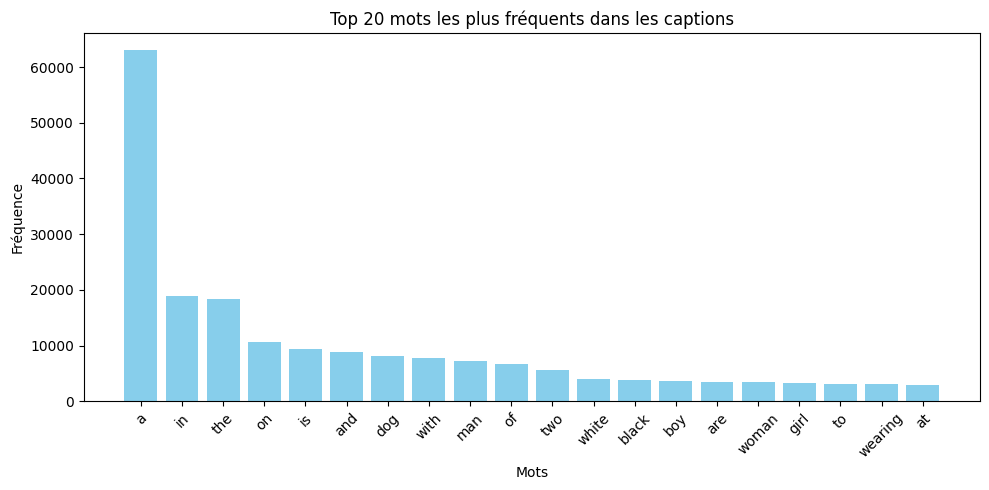

In [6]:
import matplotlib.pyplot as plt

# 📉 Top N mots à afficher
top_n = 20
most_common_words = counter.most_common(top_n)
words = [w for w, _ in most_common_words]
freqs = [f for _, f in most_common_words]

plt.figure(figsize=(10, 5))
plt.bar(words, freqs, color='skyblue')
plt.xticks(rotation=45)
plt.title(f"Top {top_n} mots les plus fréquents dans les captions")
plt.xlabel("Mots")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()


#### 🔍 Ce que tu verras :
- Une barre pour chaque mot (souvent des stopwords comme a, the, on, man, with, etc.).
- Cela t’aidera à choisir un bon seuil min_word_freq pour éviter les mots trop rares.

## 🧱 Étape 4 : Construction du vocabulaire avec seuil `min_word_freq`

### ✅ Objectif :
- Ne conserver que les mots fréquents (par ex. présents ≥ 5 fois)

- Ajouter les tokens spéciaux (`<pad>`, `<start>`, `<end>`, `<unk>`)

- Générer `word2idx` et `idx2word`

In [7]:
min_word_freq = 3  # 🔧 tu peux tester 3, 5, 10...
print(f"⚙️ Seuil de fréquence minimum : {min_word_freq}")

# 🔁 Mots conservés
words = [word for word, freq in counter.items() if freq >= min_word_freq]
print(f"🧠 Taille du vocabulaire (hors tokens spéciaux) : {len(words)}")

# 🧷 Tokens spéciaux
special_tokens = ["<pad>", "<start>", "<end>", "<unk>"]
word2idx = {token: idx for idx, token in enumerate(special_tokens, start=0)}

# 🧱 Ajout du vocab filtré
for i, word in enumerate(words, start=len(word2idx)):
    word2idx[word] = i

# 🔁 idx2word pour décodage
idx2word = {idx: word for word, idx in word2idx.items()}

print(f"🔢 Vocab final avec tokens spéciaux : {len(word2idx)} tokens")
print(f"📝 Exemple de mapping :")
for i in range(10):
    print(f"  {i}: {idx2word[i]}")


⚙️ Seuil de fréquence minimum : 3
🧠 Taille du vocabulaire (hors tokens spéciaux) : 4093
🔢 Vocab final avec tokens spéciaux : 4097 tokens
📝 Exemple de mapping :
  0: <pad>
  1: <start>
  2: <end>
  3: <unk>
  4: a
  5: child
  6: in
  7: pink
  8: dress
  9: is


## 📊 Étape 4 (bis) – Code pour tracer la courbe de couverture cumulative

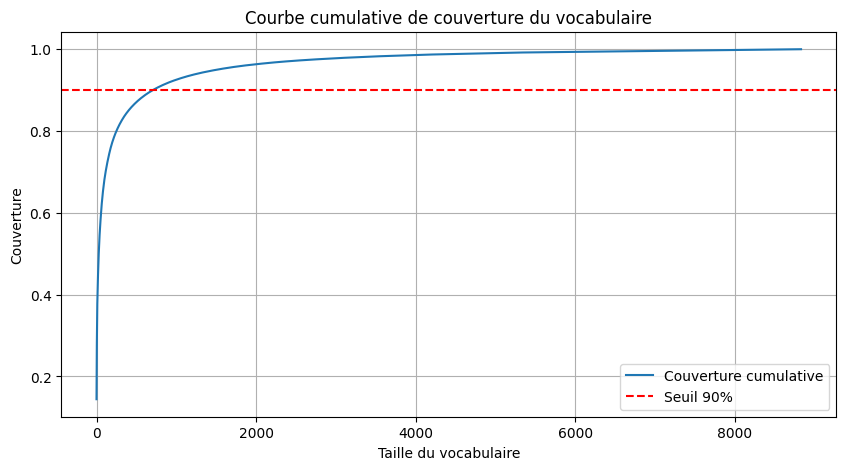

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# 🧱 Aplatir toutes les légendes nettoyées en une seule liste
cleaned_captions = []
for captions in cleaned_captions_dict.values():
    cleaned_captions.extend(captions)

# 🔁 Comptage de tous les mots dans toutes les captions
word_freq = Counter()
for caption in cleaned_captions:
    word_freq.update(caption.split())

# 🔢 Récupération des fréquences triées (du + fréquent au + rare)
frequencies = np.array(sorted(word_freq.values(), reverse=True))
total_occurrences = frequencies.sum()

# 📈 Calcul de la couverture cumulative
cumulative_coverage = np.cumsum(frequencies) / total_occurrences

# 🧪 Tracé
plt.figure(figsize=(10, 5))
plt.plot(cumulative_coverage, label="Couverture cumulative")
plt.axhline(0.9, color='r', linestyle='--', label="Seuil 90%")
plt.xlabel("Taille du vocabulaire")
plt.ylabel("Couverture")
plt.title("Courbe cumulative de couverture du vocabulaire")
plt.legend()
plt.grid()
plt.show()

## 🧩 Étape 5 : Création de la classe `Tokenizer

- Centraliser le vocabulaire (`word2idx`, `idx2word`)

- Fournir une interface pratique pour encoder/décoder des captions

- Gérer automatiquement les mots inconnus avec `<unk>`

In [9]:
class Tokenizer:
    def __init__(self, word2idx):
        self.word2idx = word2idx
        self.idx2word = {idx: word for word, idx in word2idx.items()}

        self.pad_token = "<pad>"
        self.start_token = "<start>"
        self.end_token = "<end>"
        self.unk_token = "<unk>"

        self.pad_token_id = self.word2idx[self.pad_token]
        self.start_token_id = self.word2idx[self.start_token]
        self.end_token_id = self.word2idx[self.end_token]
        self.unk_token_id = self.word2idx[self.unk_token]

        self.vocab_size = len(self.word2idx)

    def encode(self, caption, add_special_tokens=True):
        tokens = caption.strip().split()
        token_ids = [self.word2idx.get(token, self.unk_token_id) for token in tokens]

        if add_special_tokens:
            return [self.start_token_id] + token_ids + [self.end_token_id]
        else:
            return token_ids

    def decode(self, token_ids, remove_special_tokens=True):
        words = [self.idx2word.get(idx, self.unk_token) for idx in token_ids]
        if remove_special_tokens:
            words = [w for w in words if w not in [self.pad_token, self.start_token, self.end_token]]
        return " ".join(words)

#### 🔢 1. Générer word2idx limité à 2000 mots + tokens spéciaux

In [10]:
import pickle

# 🔝 Nombre de mots à conserver dans le vocab (hors tokens spéciaux)
max_vocab_size = 4000

# 📦 Tri des mots les plus fréquents
most_common_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:max_vocab_size]

# 🔁 Construction du vocab avec tokens spéciaux
special_tokens = ["<pad>", "<start>", "<end>", "<unk>"]
word2idx = {token: idx for idx, token in enumerate(special_tokens)}

for word, _ in most_common_words:
    word2idx[word] = len(word2idx)


#### 🤖 2. Créer l’objet Tokenizer

In [11]:
# 🧠 Création du tokenizer
tokenizer = Tokenizer(word2idx)

# 🔁 Exemple de test
example_caption = "A man in a red shirt is climbing a rock, it's a man mange le fromage !"
example_caption = clean_caption(example_caption)  # 🧼 Très important ici

encoded = tokenizer.encode(example_caption)
decoded = tokenizer.decode(encoded)

print("📝 Caption:", example_caption)
print("🔢 Encodée:", encoded)
print("🔤 Décodée:", decoded)


📝 Caption: a man in a red shirt is climbing a rock it's a man mange le fromage
🔢 Encodée: [1, 4, 12, 5, 4, 26, 38, 8, 120, 4, 85, 3, 4, 12, 3, 3, 3, 2]
🔤 Décodée: a man in a red shirt is climbing a rock <unk> a man <unk> <unk> <unk>


 ## 💾 Étape 6 : Sauvegarde du `Tokenizer`

### ✅ Objectif :
- Enregistrer proprement le tokenizer (et pas juste un dict)

- Le recharger facilement dans `train.py`, `evaluate.py`, etc.

In [13]:
# 💾 Sauvegarde du tokenizer dans ../data/vocab/tokenizer.pkl
# 🧠 Création de l'objet tokenizer
tokenizer = Tokenizer(word2idx)

with open("../data/vocab/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer.word2idx, f)

print("✅ Tokenizer sauvegardé sous forme d'objet complet.")

✅ Tokenizer sauvegardé sous forme d'objet complet.


## 📊 Étape 7 : Histogramme des longueurs de captions encodées

In [ ]:
import numpy as np
# 🧠 Longueurs avec tokens spéciaux
all_lengths = []

for captions in cleaned_captions_dict.values():
    for caption in captions:
        token_ids = tokenizer.encode(caption, add_special_tokens=True)
        all_lengths.append(len(token_ids))

# 📊 Visualisation
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(all_lengths, bins=range(5, max(all_lengths)+2), color="lightcoral", edgecolor="black")
plt.title("Distribution des longueurs de captions (avec <start> et <end>)")
plt.xlabel("Longueur (nb tokens)")
plt.ylabel("Nombre de captions")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"📏 Longueur moyenne : {sum(all_lengths) / len(all_lengths):.2f}")
print(f"🔝 Max length : {max(all_lengths)}")
print(f"📊 95e percentile : {int(np.percentile(all_lengths, 95))}")


#### 🔍 À quoi ça sert ?
| Info             | Utile pour...                   |
| ---------------- | ------------------------------- |
| Longueur moyenne | Estimer le padding moyen        |
| Max              | Fixer la longueur max (ex: 30)  |
| 95e percentile   | Éviter les extrêmes (cas rares) |


## 🧩 Étape 8 – Vérification de la taille du vocabulaire tokenizer.pkl

In [ ]:
import pickle

# 🔁 Chargement du tokenizer
with open("../data/vocab/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)


# 📏 Taille du vocab
vocab_size = tokenizer.vocab_size
print(f"🧠 Taille du vocabulaire (word2idx) : {vocab_size} mots")

# 🔍 Affichage rapide des 10 premiers éléments
for i, (word, idx) in enumerate(tokenizer.word2idx.items()):
    print(f"{word} → {idx}")
    if i == 9:
        break
